# Analisis exploratorio

# LIBRERIAS

In [178]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import keras
import pandas as pd
import numpy as np
from matplotlib.widgets import SpanSelector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Funciones

In [179]:
def boxplot_each_column(df):
    """
    Crea un boxplot para cada columna en un DataFrame.

    Parámetros:
    - df: pandas DataFrame
        El DataFrame que contiene los datos.

    Retorna:
    - None (muestra el boxplot)
    """
    num_cols = len(df.columns)
    num_rows = (num_cols + 2) // 3  # Calcula el número de filas con tres columnas por fila

    # Definir el tamaño de la figura en función del número de columnas
    plt.figure(figsize=(15, 3 * num_rows))

    # Iterar sobre cada columna y crear un boxplot
    for i, column in enumerate(df.columns):
        # Calcular la posición del subgráfico
        row = i // 3
        col = i % 3

        plt.subplot(num_rows, 3, i + 1)  # Organizar los subgráficos
        sns.boxplot(x=df[column])
        plt.title(f'{column}')
        plt.xlabel(column)

    plt.tight_layout()  # Ajustar el diseño de los subgráficos
    plt.show()

def select_correlated_features(df, target_column, correlation_threshold=0.5):
    """
    Selecciona las características que tienen una correlación por encima del umbral especificado con la columna objetivo.

    Parámetros:
    - df: DataFrame de pandas
        El DataFrame que contiene los datos.
    - target_column: str
        El nombre de la columna objetivo.
    - correlation_threshold: float, opcional (por defecto=0.5)
        El umbral para considerar una correlación como significativa.

    Retorna:
    - selected_features: lista
        Una lista de nombres de características que tienen una correlación significativa con la columna objetivo.
    """
    # Calcular la matriz de correlación
    corr_matrix = df.corr()

    # Seleccionar las características con una correlación por encima del umbral
    significant_features = corr_matrix[target_column][abs(corr_matrix[target_column]) >= correlation_threshold].index.tolist()

    # Eliminar la columna objetivo de la lista
    significant_features.remove(target_column)

    return significant_features

def missing_values_table(df: pd.DataFrame) -> pd.DataFrame:
    """Crea una tabla que muestra el número de valores faltantes y su porcentaje para cada columna,
    junto con el tipo de característica de cada columna que tiene valores faltantes.

    Parameters:
        df (pd.DataFrame): El DataFrame que contiene los datos.

    Returns:
        pd.DataFrame: Un DataFrame que contiene el número de valores faltantes, su porcentaje y el tipo de característica.
    """
    # Total de valores nulos o perdidos
    mis_val = df.isnull().sum()

    # Porcentaje de valores nulos
    mis_percent = 100 * df.isnull().sum() / len(df)

    # Tipo de característica de cada columna
    tipos_de_caracteristicas = df.dtypes

    # Creamos una tabla con los resultados
    mis_table = pd.concat([mis_val, mis_percent, tipos_de_caracteristicas], axis=1)

    # Renombramos las columnas
    mis_table.columns = ['Valores Faltantes', 'Porcentaje de Valores Faltantes', 'Tipo de Característica']

    # Filtramos las columnas con valores faltantes
    mis_table = mis_table[mis_table['Valores Faltantes'] != 0].sort_values(by='Porcentaje de Valores Faltantes', ascending=False).round(2)

    print("El dataframe seleccionado tiene {} filas.\n"
          "Hay {} columnas con valores perdidos.".format(df.shape[1], mis_table.shape[0]))

    return mis_table



def graficar_tendencias(df):
    """
    Genera una gráfica con las tendencias del caudal usando medias móviles.

    Parámetros:
    df (DataFrame): DataFrame con una columna 'AporCaudal' y un índice de fechas.
    """
    # Configurar el estilo visual de Seaborn
    sns.set_style("whitegrid")

    # Calcular medias móviles (tendencias)
    df_365d = df[['AporCaudal']].rolling(window=365, center=True, min_periods=360).mean()
    df_7d = df[['AporCaudal']].rolling(7, center=True).mean()

    # Crear la figura
    fig, ax = plt.subplots(figsize=(12, 6))

    # Graficar datos originales
    ax.plot(df.index, df['AporCaudal'], marker='.', markersize=2, color='gray', linestyle='None', alpha=0.6, label='Diario')
    ax.plot(df_7d.index, df_7d['AporCaudal'], linewidth=2, color='blue', label='Media móvil semanal')
    ax.plot(df_365d.index, df_365d['AporCaudal'], linewidth=3, color='darkred', label='Tendencia (Media anual)')

    ax.legend()
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Aportación de Caudal')
    ax.set_title('Tendencias en la Aportación de Caudal')
    plt.xticks(rotation=45)

    # Función de zoom
    def onselect(xmin, xmax):
        ax.set_xlim(xmin, xmax)
        fig.canvas.draw()

    # Agregar interacción de zoom
    span = SpanSelector(ax, onselect, 'horizontal', useblit=True, interactive=True)

    plt.show()



def graficar_fenomenos_ninio_ninia(df):
    """
    Función para graficar los eventos de El Niño y La Niña a lo largo del tiempo.

    Parámetros:
        df (pd.DataFrame): DataFrame con las columnas 'PosibleNino' y 'PosibleNina'.
    """
    # Convertir la columna de fechas a formato datetime si no lo está
    df.index = pd.to_datetime(df.index)

    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(14, 6))

    # Graficar los eventos de El Niño y La Niña
    ax.plot(df.index, df["PosibleNino"], label="Fenómeno El Niño", color="red", linestyle="--", alpha=0.7)
    ax.plot(df.index, df["PosibleNina"], label="Fenómeno La Niña", color="blue", linestyle="--", alpha=0.7)

    # Rellenar áreas para mejor visualización
    ax.fill_between(df.index, df["PosibleNino"], color="red", alpha=0.3)
    ax.fill_between(df.index, df["PosibleNina"], color="blue", alpha=0.3)

    # Configuración de la gráfica
    ax.set_title("Eventos de El Niño y La Niña a lo largo del tiempo")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Intensidad del Fenómeno")
    ax.legend()
    plt.grid()

    # Mostrar la gráfica
    plt.show()


def graficar_heatmap_caudal(df):
    """
    Función para generar un mapa de calor del caudal aportado por año y mes.

    Parámetros:
        df_plot (pd.DataFrame): DataFrame con las columnas 'year', 'month' y 'AporCaudal'.
    """
    df_plot=df.copy()
    # Crear tabla pivote con años como filas y meses como columnas
    df_pivot = df_plot.pivot(index="year", columns="month", values="AporCaudal")

    # Crear heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_pivot, cmap="coolwarm", annot=False, linewidths=0.5, cbar_kws={'label': 'Caudal Aportado'})

    # Configuración de la gráfica
    plt.xlabel("Mes", fontsize=12)
    plt.ylabel("Año", fontsize=12)
    plt.title("Mapa de Calor del Caudal Aportado por Año y Mes", fontsize=14)
    plt.xticks(ticks=np.arange(12), labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], rotation=45)
    plt.yticks(rotation=0)

    # Mostrar la gráfica
    plt.show()




def descomponer_serie(serie, frecuencia, modelo='additive'):
    """
    Descompone una serie temporal en tendencia, estacionalidad y residuo con gráficos mejorados.

    Parámetros:
    - serie: Serie temporal (pandas Series).
    - frecuencia: Número de periodos por ciclo (ej. 12 para datos mensuales, 365 para diarios).
    - modelo: Tipo de modelo ('additive' o 'multiplicative').

    Retorna:
    - Objeto de descomposición y gráficos con colores optimizados.
    """
    decomposed = seasonal_decompose(serie, period=frecuencia, model=modelo)

    # Graficar la descomposición con colores mejorados
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(serie, label="Serie Original", color="royalblue")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(decomposed.trend, label="Tendencia", color="red")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(decomposed.seasonal, label="Estacionalidad", color="green")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(decomposed.resid, label="Residuo", color="gray")
    plt.axhline(y=0, linestyle="dashed", color="black", linewidth=1)  # Línea base para el residuo
    plt.legend()

    plt.tight_layout()
    plt.show()

    return decomposed



def graficar_heatmap_caudal(df, columna):
    """
    Genera un mapa de calor del caudal aportado por año y mes.

    Parámetros:
        df (pd.DataFrame): DataFrame con índice de fecha.
        columna (str): Nombre de la columna que contiene los datos de caudal.
    """
    df_plot = df.copy()

    # Asegurar que el índice es de tipo datetime
    if not isinstance(df_plot.index, pd.DatetimeIndex):
        df_plot.index = pd.to_datetime(df_plot.index)

    # Extraer año y mes del índice
    df_plot["year"] = df_plot.index.year
    df_plot["month"] = df_plot.index.month

    # Agrupar por año y mes para evitar duplicados
    df_grouped = df_plot.groupby(["year", "month"])[columna].sum().reset_index()

    # Crear tabla pivote con años como filas y meses como columnas
    df_pivot = df_grouped.pivot(index="year", columns="month", values=columna)

    # Crear heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_pivot, cmap="coolwarm", annot=False, linewidths=0.5, cbar_kws={'label': 'Caudal Aportado'})

    # Configuración de la gráfica
    plt.xlabel("Mes", fontsize=12)
    plt.ylabel("Año", fontsize=12)
    plt.title("Mapa de Calor del Caudal Aportado por Año y Mes", fontsize=14)
    plt.xticks(ticks=np.arange(12), labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], rotation=45)
    plt.yticks(rotation=0)

    # Mostrar la gráfica
    plt.show()

def graficar_matriz_correlacion(df):
    """
    Genera un heatmap con la matriz de correlación de las variables numéricas.

    Parámetros:
        df (pd.DataFrame): DataFrame con los datos.
    """
    plt.figure(figsize=(15, 15))
    matriz_corr = df.corr()  # Calcula la matriz de correlación

    sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)

    plt.title("Matriz de Correlación", fontsize=14)
    plt.show()



def graficar_patrones_mensuales(df):
    """
    Función para analizar patrones mensuales del caudal aportado.

    Parámetros:
        df (pd.DataFrame): DataFrame con columnas 'Month' y 'AporCaudal'.
    """

    # Configuración del estilo de los gráficos
    sns.set(style="whitegrid")

    # Gráfico de cajas para distribución mensual
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df["Month"], y=df["AporCaudal"], palette="coolwarm")
    plt.xlabel("Mes", fontsize=12)
    plt.ylabel("Caudal Aportado", fontsize=12)
    plt.title("Distribución del Caudal por Mes", fontsize=14)
    plt.xticks(ticks=range(12), labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
    plt.show()

    # Promedio mensual del caudal aportado
    plt.figure(figsize=(12, 6))
    df.groupby("Month")["AporCaudal"].mean().plot(marker="o", linestyle="-", color="b", label="Promedio Mensual")
    plt.xlabel("Mes", fontsize=12)
    plt.ylabel("Caudal Promedio", fontsize=12)
    plt.title("Promedio Mensual del Caudal Aportado", fontsize=14)
    plt.xticks(ticks=range(1, 13), labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
    plt.legend()
    plt.grid()
    plt.show()


In [180]:
df=pd.read_csv('Aportes.csv',parse_dates=True,index_col='Date')
df.head()

,20E,70E,80E,100E,120E,140E,160E,120W,40W,10W,Year,Month,Value,PosibleNino,PosibleNina,Precipitaciones,Temperaturas,Humedades,Name,AporCaudal
Date,,,,,,,,,,,,,,,,,,,,
2000-01-01,-0.36,-0.69,-0.74,-0.30,-0.28,0.20,0.57,0.79,0.61,0.09,2000,1,-1.7,0,0,0.0,23.6,96.0,NARE,43.51
2000-01-02,-0.36,-0.69,-0.74,-0.30,-0.28,0.20,0.57,0.79,0.61,0.09,2000,1,-1.7,0,0,0.0,26.7,95.0,NARE,43.67
2000-01-03,-0.36,-0.69,-0.74,-0.30,-0.28,0.20,0.57,0.79,0.61,0.09,2000,1,-1.7,0,0,0.0,24.0,96.0,NARE,41.21
2000-01-04,0.82,0.31,-0.53,-1.02,-1.06,-0.94,-0.57,0.06,0.83,1.05,2000,1,-1.7,0,0,4.6,22.4,98.0,NARE,43.80
2000-01-05,0.82,0.31,-0.53,-1.02,-1.06,-0.94,-0.57,0.06,0.83,1.05,2000,1,-1.7,0,1,0.0,21.0,98.0,NARE,40.62


In [181]:
df.columns

Index(['20E', '70E', '80E', '100E', '120E', '140E', '160E', '120W', '40W',
       '10W', 'Year', 'Month', 'Value', 'PosibleNino', 'PosibleNina',
       'Precipitaciones', 'Temperaturas', 'Humedades', 'Name', 'AporCaudal'],
      dtype='object')

# Analisis exploratorio

In [182]:
# shape and data types of the data
print(df.shape)
print(df.info())

(8637, 20)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8637 entries, 2000-01-01 to 2023-08-31
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   20E              8637 non-null   float64
 1   70E              8637 non-null   float64
 2   80E              8637 non-null   float64
 3   100E             8637 non-null   float64
 4   120E             8637 non-null   float64
 5   140E             8637 non-null   float64
 6   160E             8637 non-null   float64
 7   120W             8637 non-null   float64
 8   40W              8637 non-null   float64
 9   10W              8637 non-null   float64
 10  Year             8637 non-null   int64  
 11  Month            8637 non-null   int64  
 12  Value            8637 non-null   float64
 13  PosibleNino      8637 non-null   int64  
 14  PosibleNina      8637 non-null   int64  
 15  Precipitaciones  8635 non-null   float64
 16  Temperaturas     8635 non-null 

In [183]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
20E,8637.0,0.071914,1.006652,-3.200,-0.610,0.100,0.790,2.82
70E,8637.0,0.018085,1.000860,-2.850,-0.680,0.020,0.740,3.02
80E,8637.0,-0.035541,1.003551,-3.280,-0.740,-0.040,0.680,3.23
100E,8637.0,-0.124096,1.009764,-3.160,-0.830,-0.140,0.570,3.52
120E,8637.0,-0.088437,1.007672,-3.110,-0.800,-0.110,0.600,3.44
140E,8637.0,-0.102273,1.008122,-2.950,-0.800,-0.140,0.570,3.30
160E,8637.0,-0.061664,1.003510,-3.110,-0.790,-0.060,0.620,2.91
120W,8637.0,-0.009787,1.006768,-3.190,-0.720,0.000,0.700,2.89
40W,8637.0,0.061261,1.015027,-3.410,-0.640,0.080,0.760,3.08
10W,8637.0,0.104130,1.011442,-3.690,-0.570,0.110,0.830,3.13


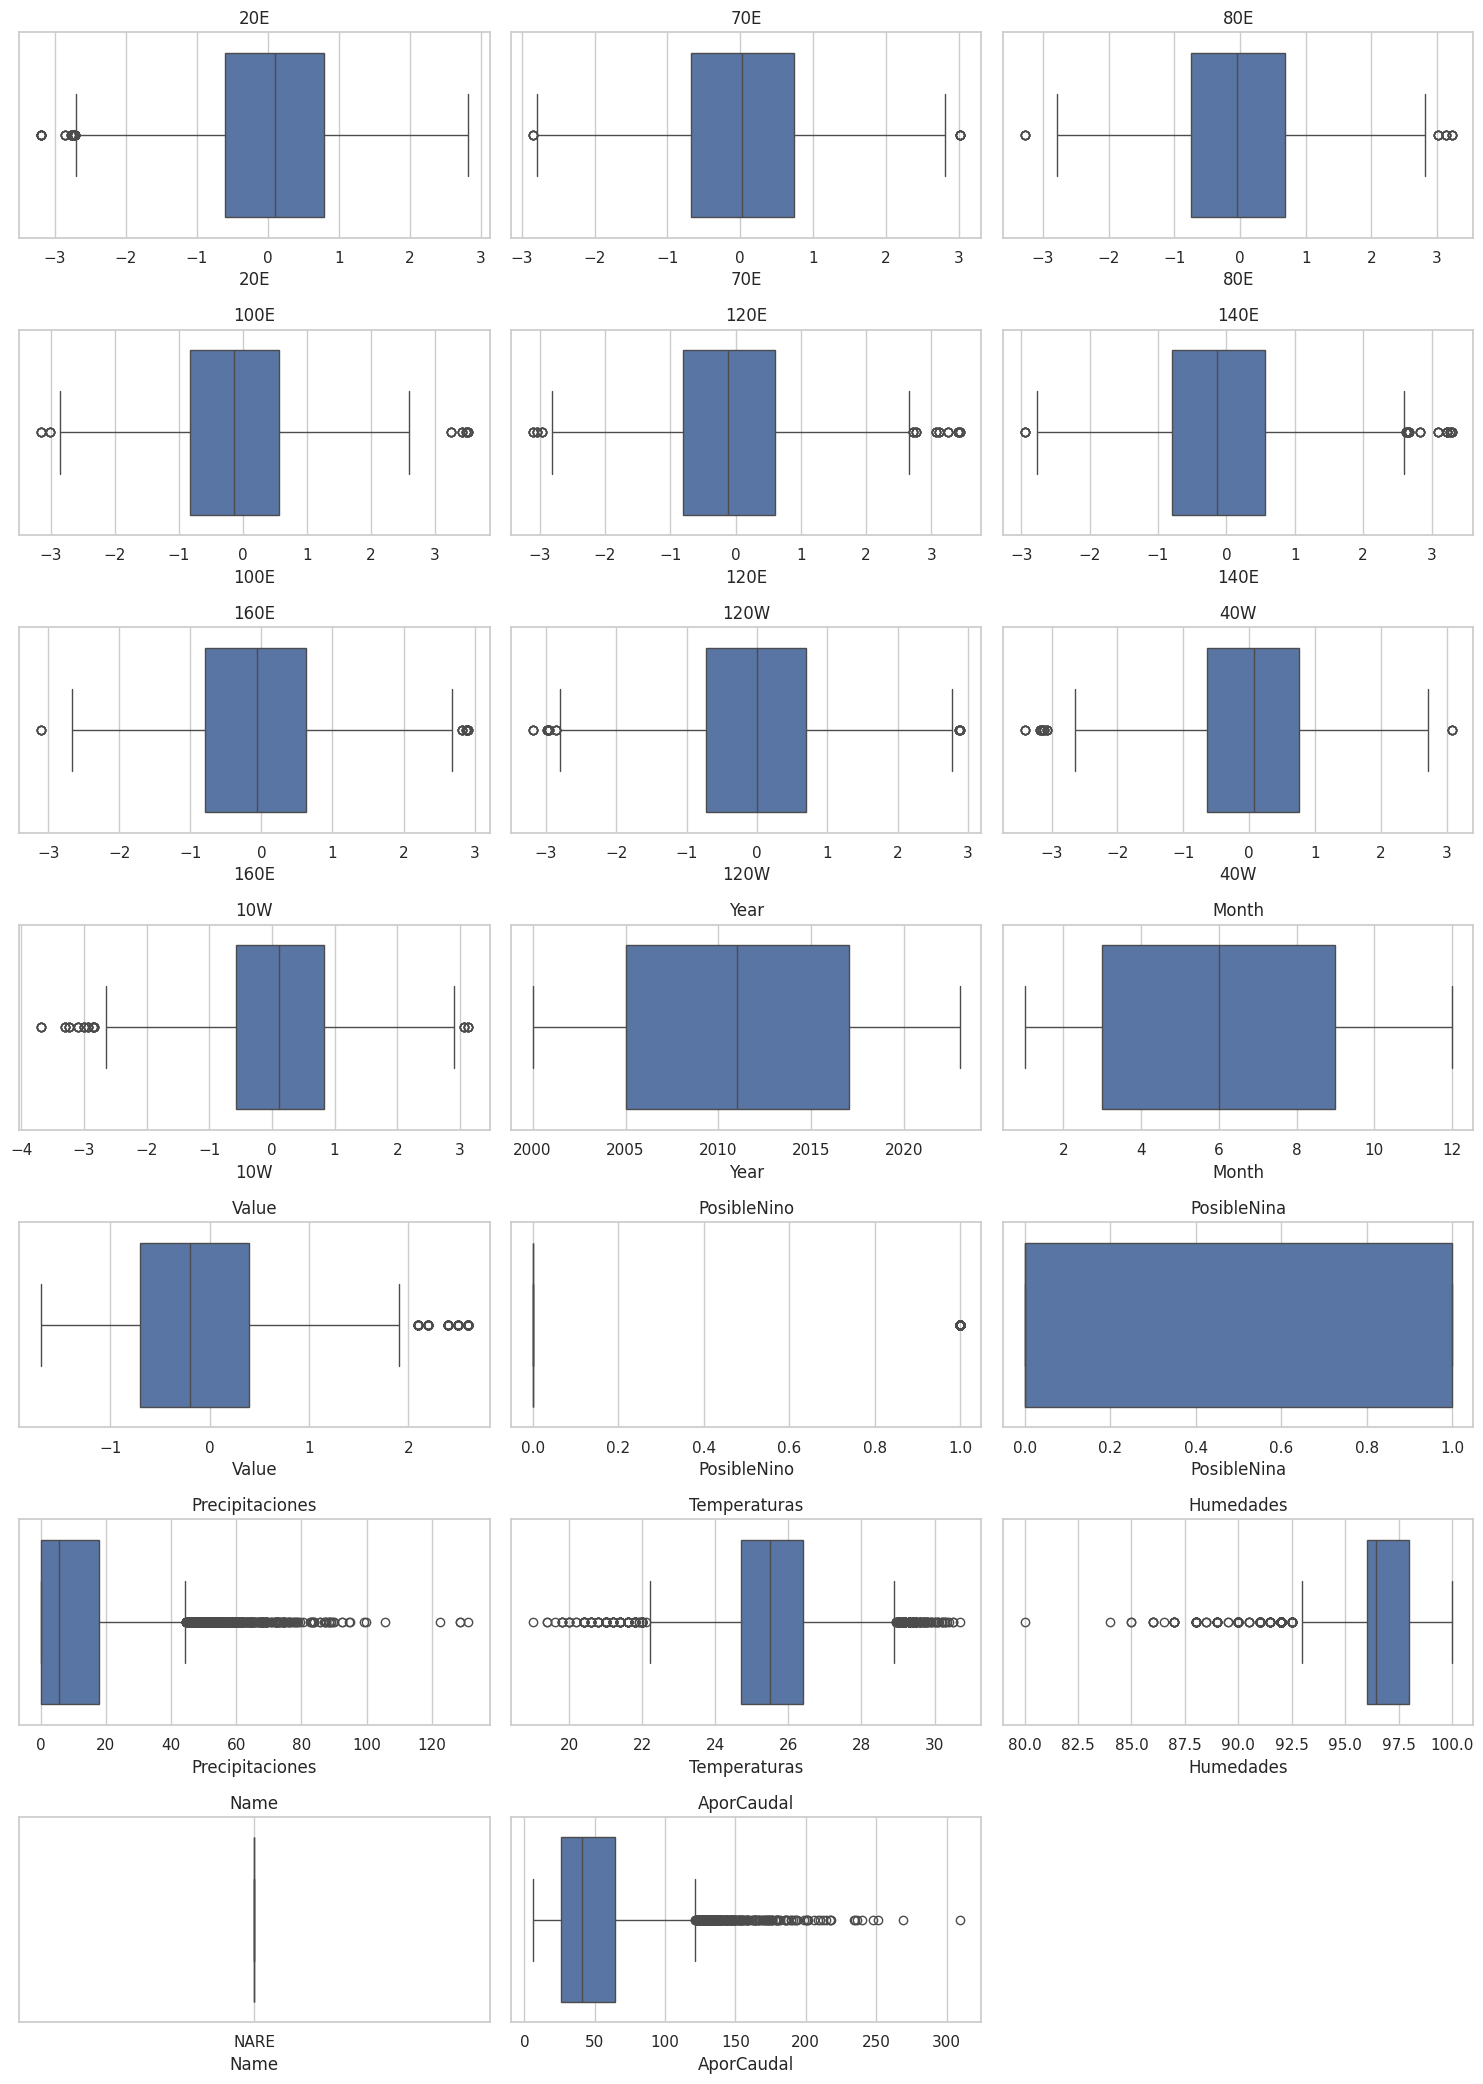

In [184]:
boxplot_each_column(df)

In [185]:
name_columns=df.columns
name_columns_number=name_columns.drop("Name")


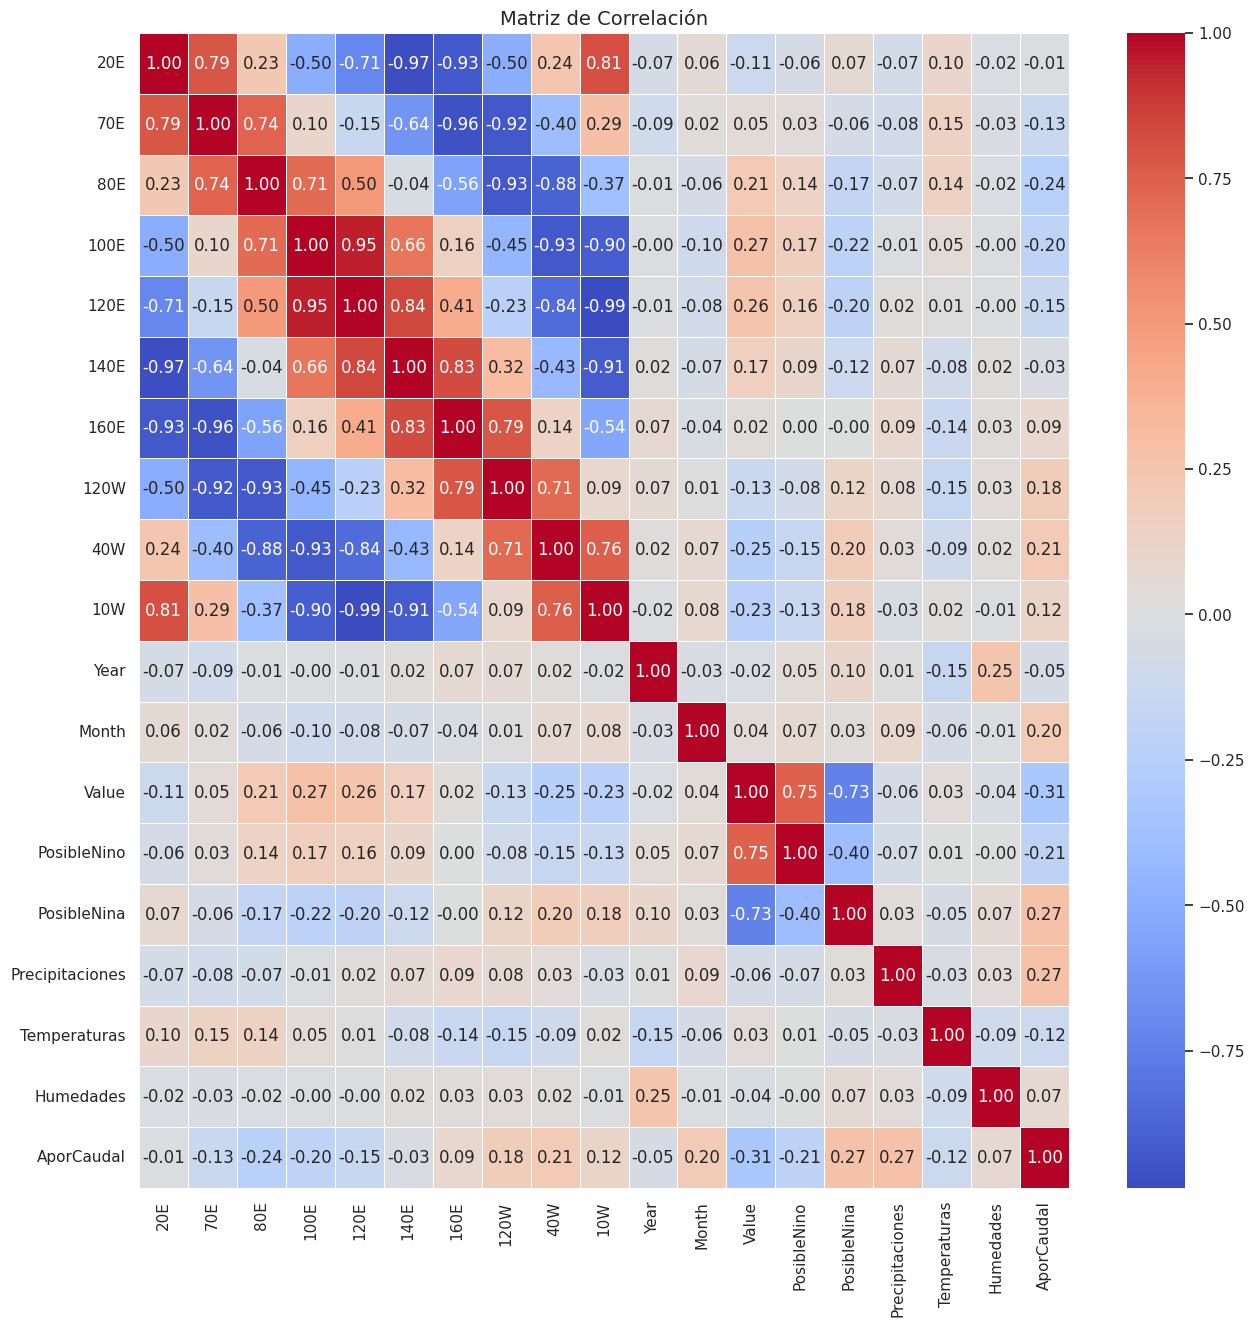

In [186]:
graficar_matriz_correlacion(df[name_columns_number])

**Precipitaciones (0.27)**

Es la variable con mayor correlación positiva con el caudal, lo cual es lógico, ya que más lluvias generalmente aumentan el caudal de los ríos.
Posible mejora: Se puede explorar un modelo no lineal, ya que la relación podría no ser estrictamente lineal.

**Posible Niño (-0.31) y Posible Niña (0.27)**

El Niño está asociado con menores caudales (correlación negativa).
La Niña tiene una relación positiva, lo que sugiere que en esos períodos el caudal aumenta.
Estos factores pueden ser esenciales para la predicción, ya que los eventos climáticos globales afectan el comportamiento de los caudales.

**Temperaturas (-0.12) y Humedades (-0.07)**

Aunque su impacto es menor, las temperaturas más altas podrían contribuir a la evaporación del agua, reduciendo el caudal.
La humedad no parece ser un predictor fuerte.
Otras Variables Espaciales (Regiones de Medición)

otras variaables  como  como 80E (-0.24) y 10W (0.12) tienen correlaciones moderadas con el caudal, lo que sugiere que podrían tener cierta influencia.
Es posible que haya patrones regionales importantes que se deban considerar en el análisis.

In [187]:
columns_strong_correlation=select_correlated_features(df[name_columns_number],"AporCaudal",0.2)

columns_strong_correlation

['80E',
 '100E',
 '40W',
 'Month',
 'Value',
 'PosibleNino',
 'PosibleNina',
 'Precipitaciones']

# Datos faltantes


In [188]:
missing_values_table(df)

El dataframe seleccionado tiene 20 filas.
Hay 3 columnas con valores perdidos.


,Valores Faltantes,Porcentaje de Valores Faltantes,Tipo de Característica
Precipitaciones,2,0.02,float64
Temperaturas,2,0.02,float64
Humedades,2,0.02,float64


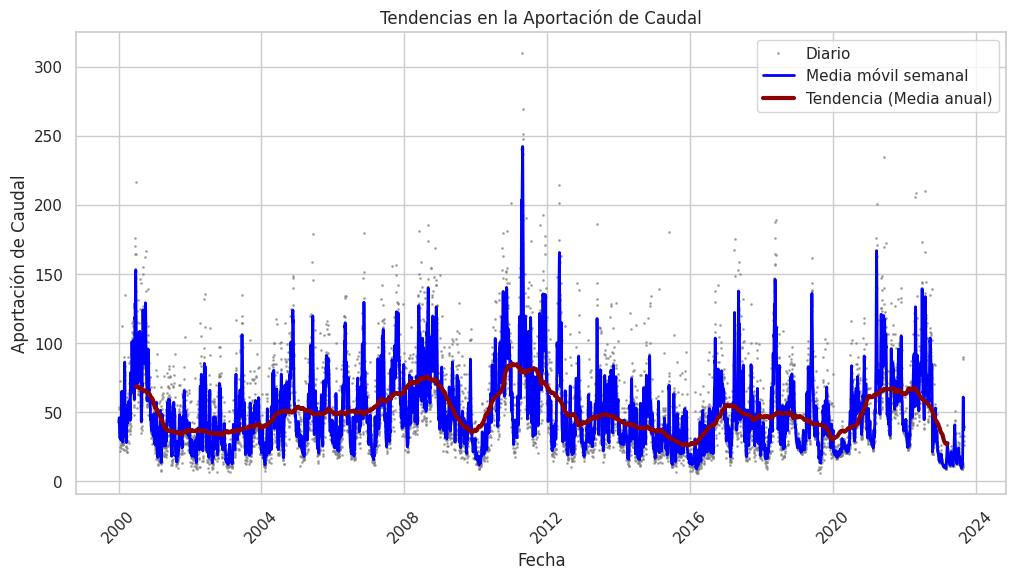

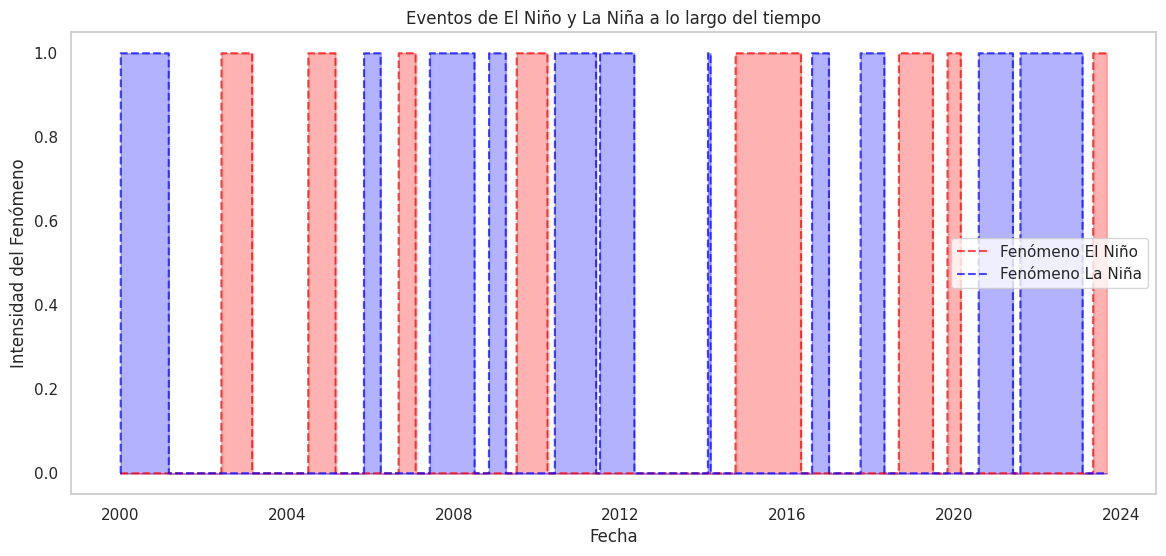

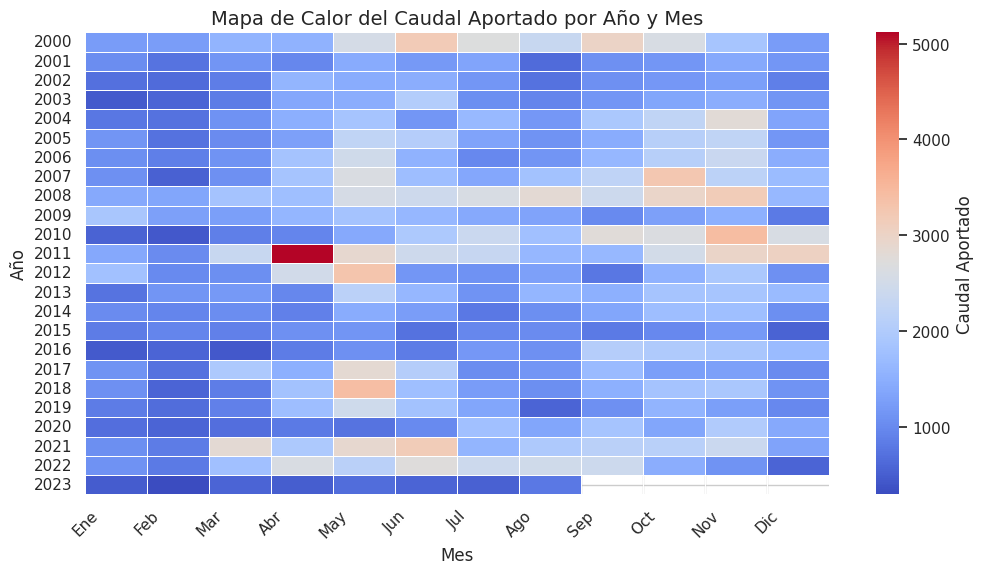

##############################


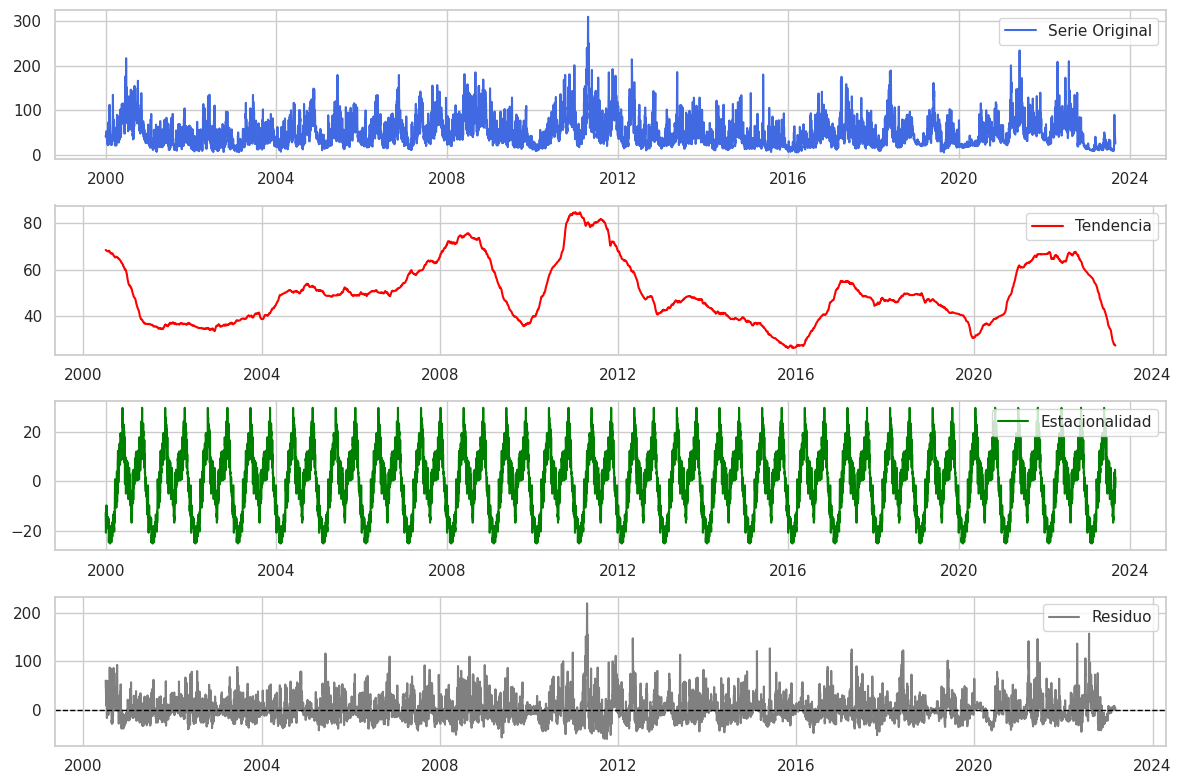

In [189]:
graficar_tendencias(df)
graficar_fenomenos_ninio_ninia(df)
graficar_heatmap_caudal(df, "AporCaudal")

print("###"*10)
descomposicion = descomponer_serie(df['AporCaudal'], frecuencia=365, modelo='additive')



### Patrón estacional y variabilidad anual:

Los ríos en Colombia suelen mostrar patrones estacionales marcados, con aumentos de caudal durante las temporadas de lluvias y disminuciones en épocas secas. Esta variabilidad está influenciada por fenómenos como El Niño y La Niña, que alteran significativamente las precipitaciones y, por ende, los caudales de los ríos.

### Eventos extremos alrededor de 2011 y 2020:

En 2010-2011, Colombia experimentó un fuerte fenómeno de La Niña, que provocó lluvias intensas y aumentos significativos en los caudales de los ríos, causando inundaciones en diversas regiones.

Entre 2020 y 2022, se registraron eventos continuos de La Niña, con precipitaciones superiores al 20% de los promedios históricos, lo que también llevó a incrementos en los caudales y eventos de inundaciones.


### Tendencias a largo plazo y variabilidad:

Estudios sobre la tendencia de los caudales en ríos colombianos indican que existen oscilaciones multianuales, con períodos de aumento y disminución del caudal promedio. Estas variaciones están asociadas a factores climáticos y antropogénicos.


Disminución reciente en 2023-2024:

Durante 2024, Colombia enfrentó una sequía prolongada, atribuida al fenómeno de El Niño, que redujo notablemente las precipitaciones y los caudales de los ríos. Esta situación llevó a riesgos de apagones y cortes de agua en varias regiones del país.
ELPAIS.COM
En resumen, las conclusiones obtenidas de la gráfica concuerdan con los datos históricos y eventos climáticos registrados en Colombia. Los patrones estacionales, eventos extremos y tendencias observadas reflejan la influencia de fenómenos como El Niño y La Niña en los caudales de los ríos colombianos




https://www.semana.com/nacion/articulo/de-el-nino-la-nina/126072-3/?utm_source=chatgpt.com


https://www.elcolombiano.com/colombia/fenomeno-de-la-nina-2010-comunidades-anos-sin-soluciones-JF11058504


https://elpais.com/america/amazonia-sin-fronteras/2024-12-02/comunidades-aisladas-escasez-de-agua-potable-y-dificultades-para-pescar-asi-vivio-la-amazonia-colombiana-su-sequia-mas-dura.html?utm_source=chatgpt.com

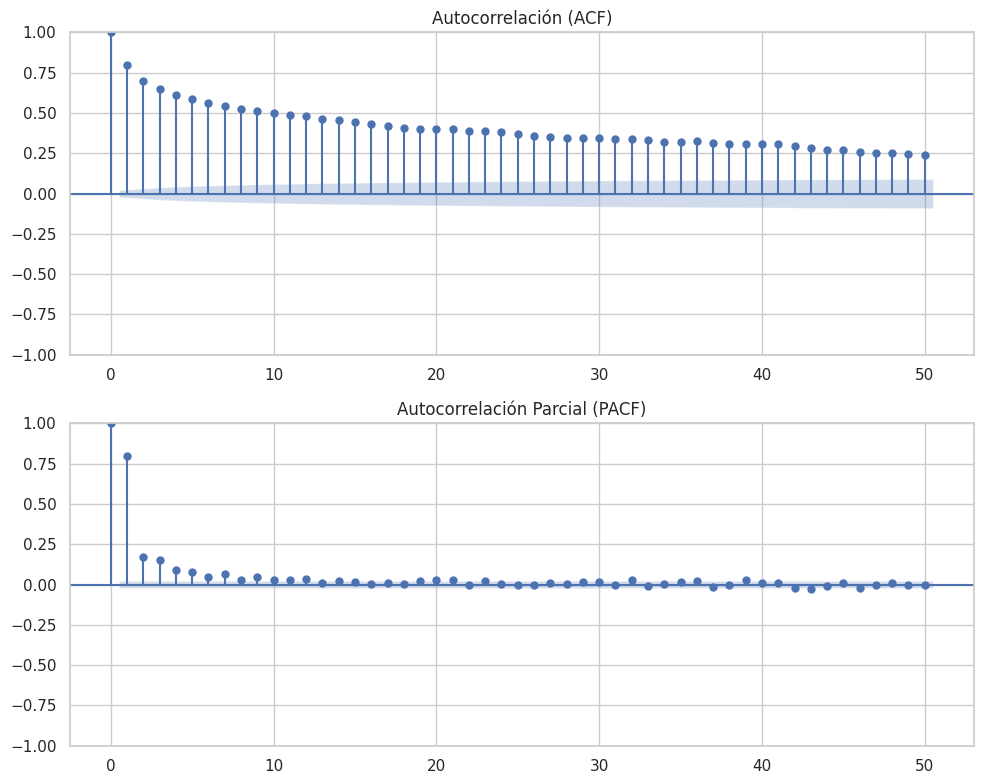

In [190]:

# Seleccionar la serie de caudal
serie_caudal = df["AporCaudal"].dropna()

# Graficar la función de autocorrelación (ACF)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(serie_caudal, lags=50, ax=ax[0])  # ACF hasta 50 retardos
ax[0].set_title("Autocorrelación (ACF)")

# Graficar la función de autocorrelación parcial (PACF)
plot_pacf(serie_caudal, lags=50, ax=ax[1])  # PACF hasta 50 retardos
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.tight_layout()
plt.show()

El análisis de autocorrelación parcial muestra que el caudal está fuertemente influenciado por su valor en el periodo anterior, pero el impacto de valores más antiguos disminuye rápidamente. Esto sugiere que los eventos recientes, como lluvias o descargas controladas, son determinantes en la evolución del caudal.

<ipython-input-179-7976ccc0d99b>:303: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Month"], y=df["AporCaudal"], palette="coolwarm")


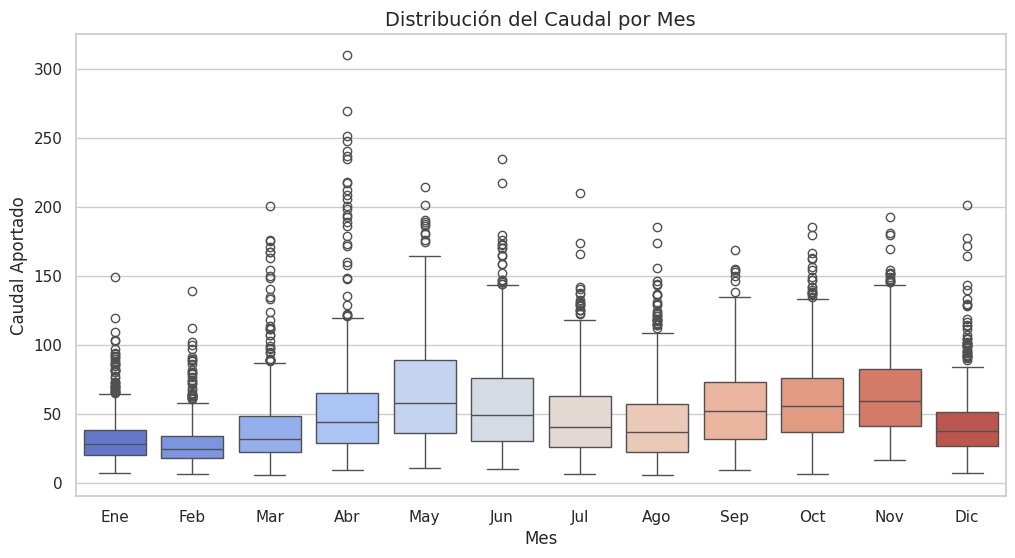

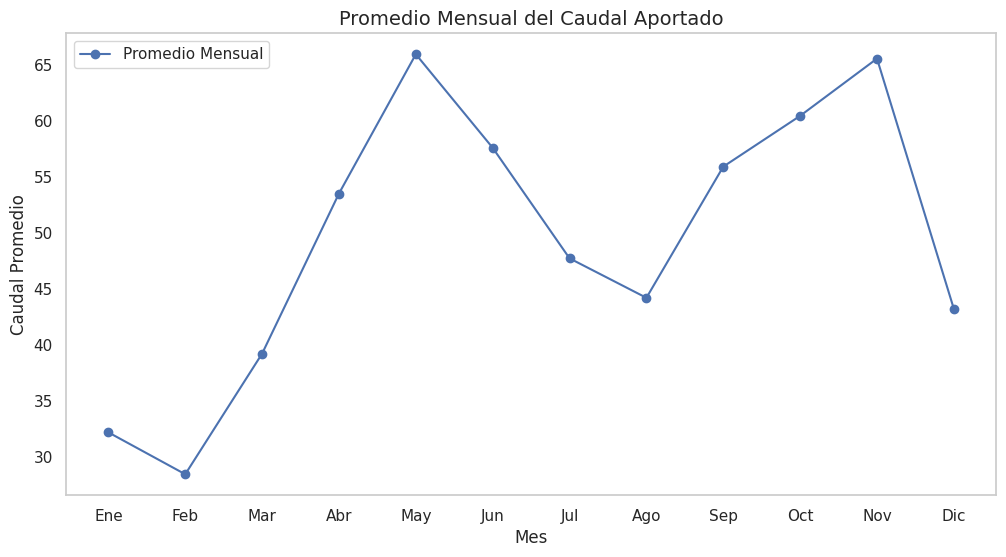

In [191]:

graficar_patrones_mensuales(df)

A partir del análisis de la gráfica del caudal aportado, se observa una variabilidad significativa a lo largo del año, con picos notorios en los meses de abril y mayo, seguidos de una disminución en los meses de julio y agosto, para luego presentar un nuevo aumento en octubre y noviembre. Esta tendencia sugiere una influencia directa de los patrones climáticos estacionales, posiblemente asociados con el régimen de lluvias y eventos como El Niño y La Niña.